In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# ------------------------------
# Step 1: Generate Synthetic Data for Shapes
# ------------------------------
def generate_cylinder(radius, height, center, num_points):
    z = np.random.uniform(0, height, num_points)
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return np.column_stack((x, y, z))

def generate_cube(length, center, num_points):
    x = np.random.uniform(center[0] - length / 2, center[0] + length / 2, num_points)
    y = np.random.uniform(center[1] - length / 2, center[1] + length / 2, num_points)
    z = np.random.uniform(center[2] - length / 2, center[2] + length / 2, num_points)
    return np.column_stack((x, y, z))

def generate_sphere(radius, center, num_points):
    phi = np.random.uniform(0, np.pi, num_points)
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)
    return np.column_stack((x, y, z))

# Generate labeled data for each shape
def generate_dataset():
    cylinder_points = generate_cylinder(radius=1, height=5, center=(0, 0, 0), num_points=1000)
    cube_points = generate_cube(length=2, center=(5, 5, 5), num_points=1000)
    sphere_points = generate_sphere(radius=1.5, center=(10, 10, 10), num_points=1000)

    # Labels: 0 = Cylinder, 1 = Cube, 2 = Sphere
    cylinder_labels = np.zeros(len(cylinder_points))
    cube_labels = np.ones(len(cube_points))
    sphere_labels = np.full(len(sphere_points), 2)

    # Combine the data and labels
    data = np.vstack((cylinder_points, cube_points, sphere_points))
    labels = np.hstack((cylinder_labels, cube_labels, sphere_labels))
    return data, labels

data, labels = generate_dataset()

# ------------------------------
# Step 2: Train-Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# ------------------------------
# Step 3: Train GMMs for Each Shape
# ------------------------------
def train_gmms(X_train, y_train, num_classes=3, n_components=3):
    gmms = {}
    for label in range(num_classes):
        # Extract points for the current class
        class_points = X_train[y_train == label]
        # Train a GMM on these points
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(class_points)
        gmms[label] = gmm
    return gmms

# Train a GMM for each shape class
gmms = train_gmms(X_train, y_train)

# ------------------------------
# Step 4: Shape Classification Using GMM Likelihoods
# ------------------------------
def predict_with_gmms(X, gmms):
    """
    Predict the shape label for each point cloud using GMM likelihoods.
    """
    likelihoods = np.zeros((X.shape[0], len(gmms)))  # Likelihoods for each class
    for label, gmm in gmms.items():
        likelihoods[:, label] = gmm.score_samples(X)  # Compute log-likelihood for each class

    return np.argmax(likelihoods, axis=1)  # Choose the class with the highest likelihood

# Predict on the test set
y_pred = predict_with_gmms(X_test, gmms)

# ------------------------------
# Step 5: Evaluate the Model
# ------------------------------
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       217
         1.0       1.00      1.00      1.00       197
         2.0       1.00      1.00      1.00       186

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Accuracy: 100.00%


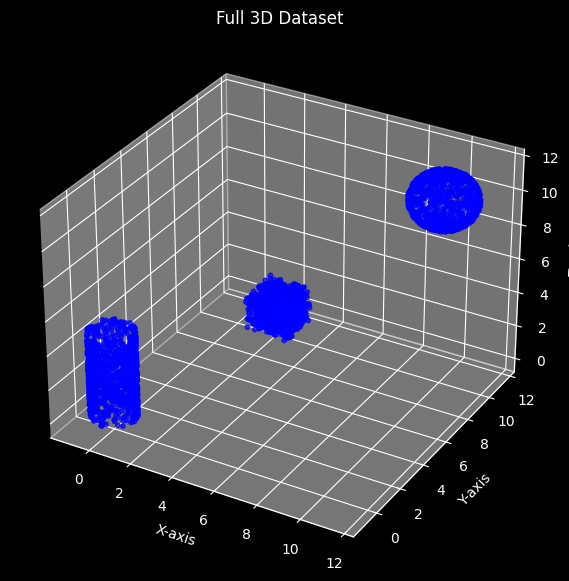

Detected Shapes:
  Cluster 0: Cylinder (Points: 217)
  Cluster 1: Cube (Points: 197)
  Cluster 2: Sphere (Points: 186)


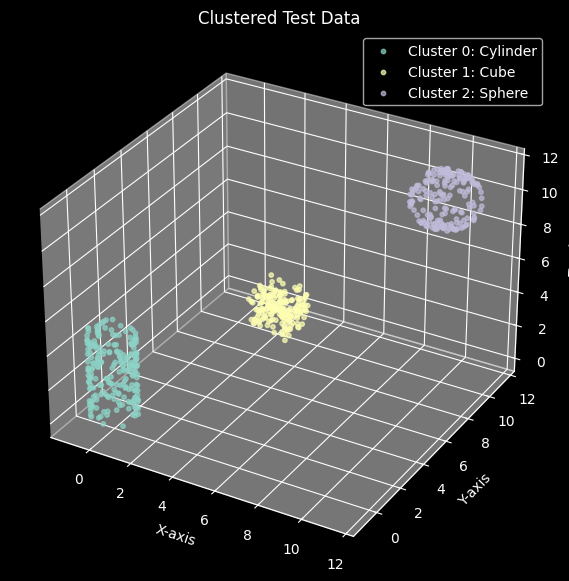

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define a mapping from cluster labels to shape names
shape_names = {0: "Cylinder", 1: "Cube", 2: "Sphere"}  # Update according to your labels

def visualize_3d_point_cloud(points, labels=None, title="3D Point Cloud"):
    """
    Visualize 3D point cloud data using matplotlib and print detected shape names.
    Args:
        points (array): Nx3 array of points (x, y, z).
        labels (array): Optional labels for coloring points by cluster.
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        # If labels are provided, color points by label and print shape names
        print("Detected Shapes:")
        for label in np.unique(labels):
            cluster_points = points[labels == label]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                       label=f"Cluster {label}: {shape_names.get(label, 'Unknown')}", s=10, alpha=0.7)
            print(f"  Cluster {label}: {shape_names.get(label, 'Unknown')} (Points: {len(cluster_points)})")
    else:
        # If no labels, plot all points with the same color
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', s=10, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    if labels is not None:
        ax.legend()
    plt.show()

# Example Usage
# Visualize the full dataset (no labels)
visualize_3d_point_cloud(data, labels=None, title="Full 3D Dataset")

# Visualize clustered data and output shape names
visualize_3d_point_cloud(X_test, y_pred, title="Clustered Test Data")


In [9]:
import open3d as o3d
import numpy as np

def visualize_with_open3d(points, labels=None):
    """
    Visualize 3D point cloud data using Open3D.
    Args:
        points (array): Nx3 array of points (x, y, z).
        labels (array): Optional labels for coloring points by cluster.
    """
    # Create Open3D point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)

    if labels is not None:
        # Assign colors based on labels
        num_labels = len(np.unique(labels))
        colors = plt.cm.get_cmap("tab10", num_labels)(labels / max(labels))
        point_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])  # RGB only

    # Visualize point cloud
    o3d.visualization.draw_geometries([point_cloud], window_name="3D Point Cloud")

# Visualize the full dataset
visualize_with_open3d(data)

# Visualize clustered data
visualize_with_open3d(X_test, y_pred)

print(labels)



[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[0. 0. 0. ... 2. 2. 2.]


/var/folders/pm/_y3ccgc55js8fzl2fwr1p2nr0000gn/T/ipykernel_21063/3133500632.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_labels)(labels / max(labels))
